In [ ]:
import numpy as np
import pandas as pd 
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import albumentations

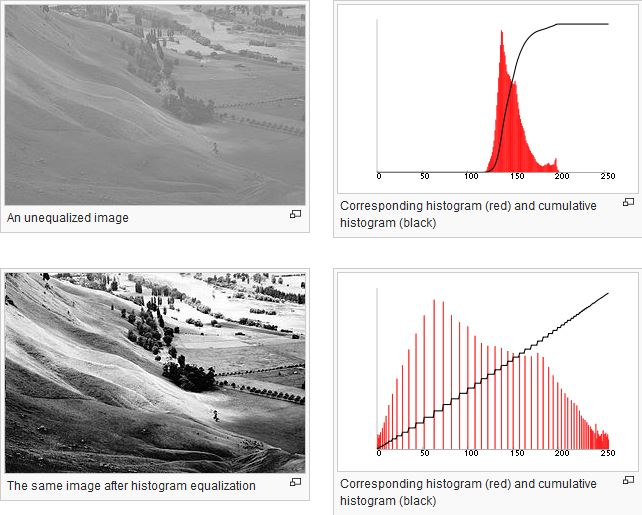

If the histogram pixels of an image are distributed in a very narrow range, then under normal circumstances, the effect of the image will be very bad. The direct impression is that the dynamic range is small and the contrast is poor; on the contrary, if the histogram is evenly extended to In the entire distribution area, the contrast of the image will be very strong.



The "central idea" of the histogram equalization processing is to change the grayscale histogram of the original image from a relatively concentrated grayscale interval to a uniform distribution in the entire grayscale range. Histogram equalization is to stretch the image non-linearly and redistribute the image pixel values ​​so that the number of pixels within a certain grayscale range is approximately the same. The histogram equalization finally changes the histogram distribution of a given image into a "uniform" histogram distribution.

# **Loading data**

In [ ]:
work_path = "../input/ranzcr-clip-catheter-line-classification/"
df = pd.read_csv(work_path+'train.csv')
file_names = df['StudyInstanceUID'].values

In [ ]:
class ImageContraster():
    def __init__(self):
        pass
    
    def enhance_contrast(self, img, method = "HE", level = 256, window_size = 32, affect_size = 16, blocks = 8, threshold = 10.0):
        ### equalize the histogram
        ### @params img : Image type
        ### @params method : Histogram Equalization Method
        ### @params level : color or gray scale
        ### @params window_size : in AHE, the window to calculate Histogram CDF size
        ### @params affect_size : in AHE, the affected pixels size
        ### @params blocks : in CLAHE, split how many times in row and col
        ### @params threshold : in CLAHE, if threshold times higher then the mean value, clip 
        ### @return img_res : equalized result
        
        # choose algorithms
        if method in ["HE", "FHE", "he", "fhe"]:
            he_func = self.histogram_equalization     # HE
        elif method in ["AHE", "ahe"]:
            he_func = self.adaptive_histequal         # AHE
        elif method in ["CLAHE", "clahe"]:
            he_func = self.contrast_limited_ahe       # CLAHE
        elif method in ["standard", "STANDARD", "Standard"]:
            he_func = self.standard_histogram_equalization   # ImageOps HE
        elif method in ["Bright", "bright", "bright_level"]: 
            he_func = self.bright_wise_histequal      # Local Region Stretch
        
        # process gray and color images
        img_arr = np.array(img)
        if len(img_arr.shape) == 2:
            channel_num = 1
        elif len(img_arr.shape) == 3:
            channel_num = img_arr.shape[2]
        
        if channel_num == 1:
            # gray image
            arr = he_func(img_arr, level = level, window_size = window_size, affect_size = affect_size, blocks = blocks, threshold = threshold)
            img_res = Image.fromarray(arr)
        elif channel_num == 3 or channel_num == 4:
            # RGB image or RGBA image(such as png)
            rgb_arr = [None] * 3
            rgb_img = [None] * 3
            # process dividely
            for k in range(3):
                rgb_arr[k] = he_func(img_arr[:,:,k], level = level, window_size = window_size, affect_size = affect_size, blocks = blocks, threshold = threshold)
                rgb_img[k] = Image.fromarray(rgb_arr[k])
            img_res = Image.merge("RGB", tuple(rgb_img))
        
        return img_res
    
    def histogram_equalization(self, img_arr, level = 256, **args):
        ### equalize the distribution of histogram to enhance contrast
        ### @params img_arr : numpy.array uint8 type, 2-dim
        ### @params level : the level of gray scale
        ### @return arr : the equalized image array
        
        # calculate hists
        hists = self.calc_histogram_(img_arr, level)
        
        # equalization
        (m, n) = img_arr.shape
        hists_cdf = self.calc_histogram_cdf_(hists, m, n, level)  # calculate CDF
        
        arr = np.zeros_like(img_arr)
        arr = hists_cdf[img_arr]        # mapping
        
        return arr
    
    def adaptive_histequal(self, img_arr, level = 256, window_size = 32, affect_size = 16, **args):
        ### using AHE to enhance contrast
        ### @params img_arr : numpy.array uint8 type, 2-dim
        ### @params level : the level of gray scale
        ### @params window_size : calculate the histogram mapping function in a window of (window_size, window_size)
        ### @params affect_size : the real affected pixels by a mapping function
        ### @return arr : the equalized image array
        arr = img_arr.copy()
        
        # calculate how many blocks needed in row-axis and col-axis
        (m, n) = img_arr.shape
        if (m - window_size) % affect_size == 0:
            rows = int((m - window_size)/affect_size + 1)
        else:
            rows = int((m - window_size)/affect_size + 2)
        if (n - window_size) % affect_size == 0:
            cols = int((n - window_size)/affect_size + 1)
        else:
            cols = int((n - window_size)/affect_size + 2)
        
        # equalize histogram of every block image
        for i in range(rows):
            for j in range(cols):
                # offset
                off = int((window_size - affect_size) / 2)
                
                # affect region border
                asi, aei = i * affect_size + off, (i + 1) * affect_size + off
                asj, aej = j * affect_size + off, (j + 1) * affect_size + off
                
                # window region border
                wsi, wei = i * affect_size, i * affect_size + window_size
                wsj, wej = j * affect_size, j * affect_size + window_size
                
                # equalize the window region
                window_arr = img_arr[wsi : wei, wsj : wej]
                block_arr = self.histogram_equalization(window_arr, level)
                
                # border case
                if i == 0:
                    arr[wsi : asi, wsj : wej] = block_arr[0 : asi - wsi, :]
                elif i >= rows - 1:
                    arr[aei : wei, wsj : wej] = block_arr[aei - wsi : wei - wsi, :]
                if j == 0:
                    arr[wsi : wei, wsj : asj] = block_arr[:, 0 : asj - wsj]
                elif j >= cols - 1:
                    arr[wsi : wei, aej : wej] = block_arr[: , aej - wsj : wej - wsj]
                arr[asi : aei, asj : aej] = block_arr[asi - wsi : aei - wsi, asj - wsj : aej - wsj]
                
        return arr
    
    def contrast_limited_ahe(self, img_arr, level = 256, blocks = 8, threshold = 10.0, **args):
        ### equalize the distribution of histogram to enhance contrast, using CLAHE
        ### @params img_arr : numpy.array uint8 type, 2-dim
        ### @params level : the level of gray scale
        ### @params window_size : the window used to calculate CDF mapping function
        ### @params threshold : clip histogram by exceeding the threshold times of the mean value
        ### @return arr : the equalized image array
        (m, n) = img_arr.shape
        block_m = int(m / blocks)
        block_n = int(n / blocks)
        
        # split small regions and calculate the CDF for each, save to a 2-dim list
        maps = []
        for i in range(blocks):
            row_maps = []
            for j in range(blocks):
                # block border
                si, ei = i * block_m, (i + 1) * block_m
                sj, ej = j * block_n, (j + 1) * block_n
                
                # block image array
                block_img_arr = img_arr[si : ei, sj : ej]
                
                # calculate histogram and cdf
                hists = self.calc_histogram_(block_img_arr)
                clip_hists = self.clip_histogram_(hists, threshold = threshold)     # clip histogram
                hists_cdf = self.calc_histogram_cdf_(clip_hists, block_m, block_n, level)
                
                # save
                row_maps.append(hists_cdf)
            maps.append(row_maps)
        
        # interpolate every pixel using four nearest mapping functions
        # pay attention to border case
        arr = img_arr.copy()
        for i in range(m):
            for j in range(n):
                r = int((i - block_m / 2) / block_m)      # the row index of the left-up mapping function
                c = int((j - block_n / 2) / block_n)      # the col index of the left-up mapping function
                
                x1 = (i - (r + 0.5) * block_m) / block_m  # the x-axis distance to the left-up mapping center
                y1 = (j - (c + 0.5) * block_n) / block_n  # the y-axis distance to the left-up mapping center
                
                lu = 0    # mapping value of the left up cdf
                lb = 0    # left bottom
                ru = 0    # right up
                rb = 0    # right bottom
                
                # four corners use the nearest mapping directly
                if r < 0 and c < 0:
                    arr[i][j] = maps[r + 1][c + 1][img_arr[i][j]]
                elif r < 0 and c >= blocks - 1:
                    arr[i][j] = maps[r + 1][c][img_arr[i][j]]
                elif r >= blocks - 1 and c < 0:
                    arr[i][j] = maps[r][c + 1][img_arr[i][j]]
                elif r >= blocks - 1 and c >= blocks - 1:
                    arr[i][j] = maps[r][c][img_arr[i][j]]
                # four border case using the nearest two mapping : linear interpolate
                elif r < 0 or r >= blocks - 1:
                    if r < 0:
                        r = 0
                    elif r > blocks - 1:
                        r = blocks - 1
                    left = maps[r][c][img_arr[i][j]]
                    right = maps[r][c + 1][img_arr[i][j]]
                    arr[i][j] = (1 - y1) * left + y1 * right
                elif c < 0 or c >= blocks - 1:
                    if c < 0:
                        c = 0
                    elif c > blocks - 1:
                        c = blocks - 1
                    up = maps[r][c][img_arr[i][j]]
                    bottom = maps[r + 1][c][img_arr[i][j]]
                    arr[i][j] = (1 - x1) * up + x1 * bottom
                # bilinear interpolate for inner pixels
                else:
                    lu = maps[r][c][img_arr[i][j]]
                    lb = maps[r + 1][c][img_arr[i][j]]
                    ru = maps[r][c + 1][img_arr[i][j]]
                    rb = maps[r + 1][c + 1][img_arr[i][j]]
                    arr[i][j] = (1 - y1) * ( (1 - x1) * lu + x1 * lb) + y1 * ( (1 - x1) * ru + x1 * rb)
        arr = arr.astype("uint8")
        return arr
    
    def bright_wise_histequal(self, img_arr, level = 256, **args):
        ### split the image to three level accoding brightness, equalize histogram dividely
        ### @params img_arr : numpy.array uint8 type, 2-dim
        ### @params level : gray scale
        ### @return arr : the equalized image array
        def special_histogram(img_arr, min_v, max_v):
            ### calculate a special histogram with max, min value
            ### @params img_arr : 1-dim numpy.array
            ### @params min_v : min gray scale
            ### @params max_v : max gray scale
            ### @return hists : list type, length = max_v - min_v + 1
            hists = [0 for _ in range(max_v - min_v + 1)]
            for v in img_arr:
                hists[v - min_v] += 1
            return hists
        def special_histogram_cdf(hists, min_v, max_v):
            ### calculate a special histogram cdf with max, min value
            ### @params hists : list type
            ### @params min_v : min gray scale
            ### @params max_v : max gray scale
            ### @return hists_cdf : numpy.array
            hists_cumsum = np.cumsum(np.array(hists))
            hists_cdf = (max_v - min_v) / hists_cumsum[-1] * hists_cumsum + min_v
            hists_cdf = hists_cdf.astype("uint8")
            return hists_cdf
        def pseudo_variance(arr):
            ### caluculate a type of variance
            ### @params arr : 1-dim numpy.array
            arr_abs = np.abs(arr - np.mean(arr))
            return np.mean(arr_abs)
            
        # search two grayscale level, which can split the image into three parts having approximately same number of pixels
        (m, n) = img_arr.shape
        hists = self.calc_histogram_(img_arr)
        hists_arr = np.cumsum(np.array(hists))
        hists_ratio = hists_arr / hists_arr[-1]
        
        scale1 = None
        scale2 = None
        for i in range(len(hists_ratio)):
            if hists_ratio[i] >= 0.333 and scale1 == None:
                scale1 = i
            if hists_ratio[i] >= 0.667 and scale2 == None:
                scale2 = i
                break
        
        # split images
        dark_index = (img_arr <= scale1)
        mid_index = (img_arr > scale1) & (img_arr <= scale2)
        bright_index = (img_arr > scale2)
        
        # variance
        dark_variance = pseudo_variance(img_arr[dark_index])
        mid_variance = pseudo_variance(img_arr[mid_index])
        bright_variance = pseudo_variance(img_arr[bright_index])
        
        # build three level images
        dark_img_arr = np.zeros_like(img_arr)
        mid_img_arr = np.zeros_like(img_arr)
        bright_img_arr = np.zeros_like(img_arr)
        
        # histogram equalization individually
        dark_hists = special_histogram(img_arr[dark_index], 0, scale1)
        dark_cdf = special_histogram_cdf(dark_hists, 0, scale1)
        
        mid_hists = special_histogram(img_arr[mid_index], scale1, scale2)
        mid_cdf = special_histogram_cdf(mid_hists, scale1, scale2)
        
        bright_hists = special_histogram(img_arr[bright_index], scale2, level - 1)
        bright_cdf = special_histogram_cdf(bright_hists, scale2, level - 1)
        
        
        def plot_hists(arr):
            hists = [0 for i in range(256)]
            for a in arr:
                hists[a] += 1
            self.draw_histogram_(hists)
        
        # mapping
        dark_img_arr[dark_index] = dark_cdf[img_arr[dark_index]]
        mid_img_arr[mid_index] = mid_cdf[img_arr[mid_index] - scale1]
        bright_img_arr[bright_index] = bright_cdf[img_arr[bright_index] - scale2]
        
        # weighted sum
        #fractor = dark_variance + mid_variance + bright_variance
        #arr = (dark_variance * dark_img_arr + mid_variance * mid_img_arr + bright_variance * bright_img_arr)/fractor
        arr = dark_img_arr + mid_img_arr + bright_img_arr
        arr = arr.astype("uint8")
        return arr
    
    def standard_histogram_equalization(self, img_arr, level = 256, **args):
        ### equalize the distribution of histogram to enhance contrast, using PIL.ImageOps
        ### @params img_arr : numpy.array uint8 type, 2-dim
        ### @params level : the level of gray scale
        ### @return arr : the equalized image array
        
        # ImageOps.equalize
        img = Image.fromarray(img_arr)
        img_res = ImageOps.equalize(img)
        arr = np.array(img_res)
        return arr
    
    def calc_histogram_(self, gray_arr, level = 256):
        ### calculate the histogram of a gray scale image
        ### @params gray_arr : numpy.array uint8 type, 2-dim
        ### @params level : the level of gray scale
        ### @return hists : list type
        hists = [0 for _ in range(level)]
        for row in gray_arr:
            for p in row:
                hists[p] += 1
        return hists
    
    def calc_histogram_cdf_(self, hists, block_m, block_n, level = 256):
        ### calculate the CDF of the hists
        ### @params hists : list type
        ### @params block_m : the histogram block's height
        ### @params block_n : the histogram block's width
        ### @params level : the level of gray scale
        ### @return hists_cdf : numpy.array type
        hists_cumsum = np.cumsum(np.array(hists))
        const_a = (level - 1) / (block_m * block_n)
        hists_cdf = (const_a * hists_cumsum).astype("uint8")
        return hists_cdf
    
    def clip_histogram_(self, hists, threshold = 10.0):
        ### clip the peak of histogram, and separate it to all levels uniformly
        ### @params hists : list type
        ### @params threshold : the top ratio of hists over mean value
        ### @return clip_hists : list type
        all_sum = sum(hists)
        threshold_value = all_sum / len(hists) * threshold
        total_extra = sum([h - threshold_value for h in hists if h >= threshold_value])
        mean_extra = total_extra / len(hists)
        
        clip_hists = [0 for _ in hists]
        for i in range(len(hists)):
            if hists[i] >= threshold_value:
                clip_hists[i] = int(threshold_value + mean_extra)
            else:
                clip_hists[i] = int(hists[i] + mean_extra)
        
        return clip_hists
    
    def draw_histogram_(self, hists):
        ### draw a bar picture of the given histogram
        plt.figure()
        plt.bar(range(len(hists)), hists)
        plt.show()
    
    def plot_images(self, img1, img2):
        ### draw two images
        ### @params img1 : Image type
        ### @params img2 : Image type
        plt.figure()
        plt.subplot(121)
        plt.imshow(img1)
        plt.subplot(122)
        plt.imshow(img2)
        plt.show()

icter = ImageContraster()

# HE：Histogram Equalization 
# Adjust the brightness distribution of pixels to ensure that the histogram has the maximum dynamic range,, make the gray histogram a rectangle as much as possible

In [ ]:
for i in range(3):
    path = os.path.join(work_path,"train",file_names[i]+".jpg")
    img = cv2.imread(path)
    img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    he_eq_img = icter.enhance_contrast(img, method = "HE")
    icter.plot_images(img, he_eq_img)

#  AHE：Adaptive Histogram Equalization

#  Divided  original image into sub regions, and each sub region using Histogram Equalization

In [ ]:
for i in range(3):
    path = os.path.join(work_path,"train",file_names[i]+".jpg")
    img = cv2.imread(path)
    img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    ahe_eq_img = icter.enhance_contrast(img, method = "AHE", window_size = 200, affect_size = 50)
    icter.plot_images(img, ahe_eq_img)

# CLAHE:Contrast Limited Adaptive Histogram Equalization

In [ ]:
for i in range(3):
    path = os.path.join(work_path,"train",file_names[i]+".jpg")
    img = cv2.imread(path)
    img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    clahe_eq_img = icter.enhance_contrast(img, method = "CLAHE", blocks = 9, threshold = 10.0)
    icter.plot_images(img, clahe_eq_img)

# CLAHE in Albumentations

In [ ]:
aug = albumentations.CLAHE(clip_limit=(1,4), p=1)
for i in range(3):
    path = os.path.join(work_path,"train",file_names[i]+".jpg")
    img = cv2.imread(path)
    img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    clahe = aug(image = img)["image"]
    icter.plot_images(img, clahe)